In [1]:
import numpy as np
import nolearn
import sklearn.linear_model as lm
import scipy.stats as sps
import math

from decimal import Decimal
from lasagne import layers, nonlinearities
from lasagne.updates import nesterov_momentum
from lasagne import layers
from nolearn.lasagne import NeuralNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using gpu device 0: Quadro 2000


In [12]:
import custom_funcs as cf
cf.init_seaborn('white', 'poster')
from isoelectric_point import isoelectric_points
from molecular_weight import molecular_weights

In [13]:
# Read in the protease inhibitor data
data, drug_cols, feat_cols = cf.read_data('hiv-protease-data.csv', n_data_cols=8)

# Read in the consensus data
consensus_map = cf.read_consensus('hiv-protease-consensus.fasta')

# Clean the data
data = cf.clean_data(data, feat_cols, consensus_map)

# Identify non-conserved calls
nonconserved_cols = cf.identify_nonconserved_cols(data, feat_cols)
data = cf.drop_conserved_cols(data, feat_cols, nonconserved_cols)
data = cf.drop_ambiguous_sequences(data, feat_cols, nonconserved_cols)

In [34]:
print(drug_cols)

DRUG = 'NFV'

Index(['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV'], dtype='object')


In [35]:
X, Y = cf.split_data_xy(data, nonconserved_cols, DRUG)

X_binarized, X_binarizers = cf.binarize_seqfeature(X)

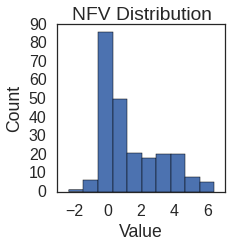

In [36]:
import matplotlib.pyplot as plt
std = (3,3)
fig = cf.plot_Y_histogram(Y, DRUG, figsize=std)

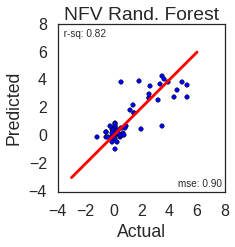

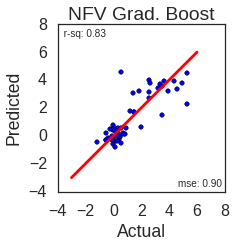

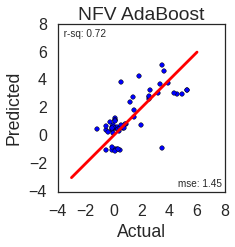

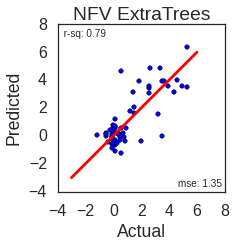

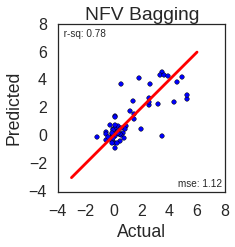

In [37]:
tts_data = X_train, X_test, Y_train, Y_test = train_test_split(X_binarized, Y)

# Train a bunch of ensemble learners
kwargs = {'n_jobs':-1, 'n_estimators':1000}
rfr, rfr_preds, rfr_mse, rfr_r2 = cf.train_model(*tts_data, model=RandomForestRegressor, modelargs=kwargs)
kwargs = {'n_estimators':1000}
gbr, gbr_preds, gbr_mse, gbr_r2 = cf.train_model(*tts_data, model=GradientBoostingRegressor, modelargs=kwargs)
kwargs = {'n_estimators':1000}
abr, abr_preds, abr_mse, abr_r2 = cf.train_model(*tts_data, model=AdaBoostRegressor, modelargs=kwargs)

etr, etr_preds, etr_mse, etr_r2 = cf.train_model(*tts_data, model=ExtraTreesRegressor)

bgr, bgr_preds, bgr_mse, bgr_r2 = cf.train_model(*tts_data, model=BaggingRegressor)

std = (3,3)
cf.scatterplot_results(rfr_preds, Y_test, rfr_mse, rfr_r2, DRUG, 'Rand. Forest', figsize=std)
cf.scatterplot_results(gbr_preds, Y_test, gbr_mse, gbr_r2, DRUG, 'Grad. Boost', figsize=std)
cf.scatterplot_results(abr_preds, Y_test, abr_mse, abr_r2, DRUG, 'AdaBoost', figsize=std)
cf.scatterplot_results(etr_preds, Y_test, etr_mse, etr_r2, DRUG, 'ExtraTrees', figsize=std)
cf.scatterplot_results(bgr_preds, Y_test, bgr_mse, bgr_r2, DRUG, 'Bagging', figsize=std)

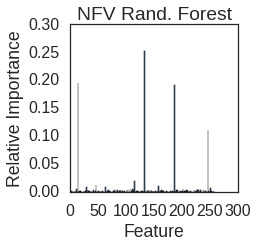

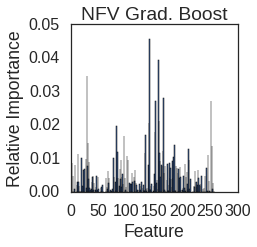

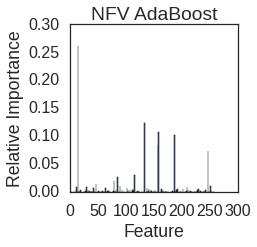

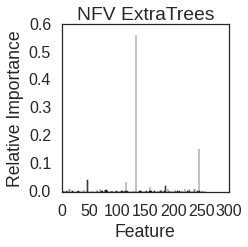

In [38]:
std = (3,3)
cf.barplot_feature_importances(rfr, DRUG, 'Rand. Forest', figsize=std)
cf.barplot_feature_importances(gbr, DRUG, 'Grad. Boost', figsize=std)
cf.barplot_feature_importances(abr, DRUG, 'AdaBoost', figsize=std)
cf.barplot_feature_importances(etr, DRUG, 'ExtraTrees', figsize=std)
# cf.barplot_feature_importances(bgr, DRUG, 'Bagging') ## feature_importances_ do not exist for bagging

In [39]:
rfr_fi = cf.extract_mutational_importance(rfr, X_test)
gbr_fi = cf.extract_mutational_importance(gbr, X_test)
abr_fi = cf.extract_mutational_importance(abr, X_test)


# joined = rfr_fi.set_index(0).join(gbr_fi.set_index(0), lsuffix='r', rsuffix='g')
# sps.spearmanr(joined['1r'], joined['1g'])

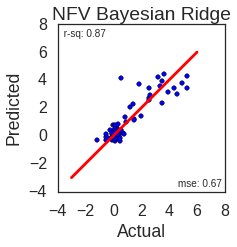

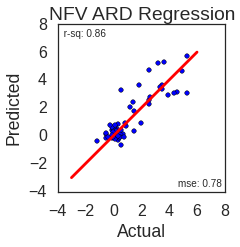

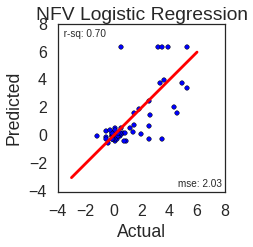

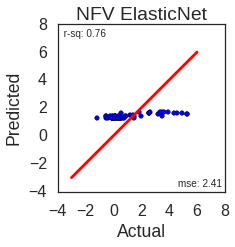

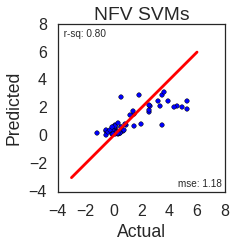

In [40]:
# Train a bunch of linear model learners for comparison.
brr, brr_preds, brr_mse, brr_r2 = cf.train_model(*tts_data, model=lm.BayesianRidge)
ard, ard_preds, ard_mse, ard_r2 = cf.train_model(*tts_data, model=lm.ARDRegression)
logr, logr_preds, logr_mse, logr_r2 = cf.train_model(*tts_data, model=lm.LogisticRegression)
enr, enr_preds, enr_mse, enr_r2 = cf.train_model(*tts_data, model=lm.ElasticNet)
svr, svr_preds, svr_mse, svr_r2 = cf.train_model(*tts_data, model=SVR)

cf.scatterplot_results(brr_preds, Y_test, brr_mse, brr_r2, DRUG, 'Bayesian Ridge', figsize=std)
cf.scatterplot_results(ard_preds, Y_test, ard_mse, ard_r2, DRUG, 'ARD Regression', figsize=std)
cf.scatterplot_results(logr_preds, Y_test, logr_mse, logr_r2, DRUG, 'Logistic Regression', figsize=std)
cf.scatterplot_results(enr_preds, Y_test, enr_mse, enr_r2, DRUG, 'ElasticNet', figsize=std)
cf.scatterplot_results(svr_preds, Y_test, svr_mse, svr_r2, DRUG, 'SVMs', figsize=std)

In [41]:
# Neural Network 1 Specification: Feed Forward ANN with 1 hidden layer.
# x_train, x_test, y_train, y_test = train_test_split(drug_X_bi, drug_Y)

x_train = X_train.astype(np.float32)
y_train = Y_train.astype(np.float32)
x_test = X_test.astype(np.float32)
y_test = Y_test.astype(np.float32)

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        #('hidden2', layers.DenseLayer),
        #('dropout2', layers.DropoutLayer),
        ('nonlinear', layers.NonlinearityLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, x_train.shape[1]),  # 
    hidden1_num_units=math.ceil(x_train.shape[1] / 2),  # number of units in hidden layer
    hidden1_nonlinearity=nonlinearities.tanh,
    dropout1_p = 0.5,
    #hidden2_num_units=math.ceil(x_train.shape[1] / 2),
    #dropout2_p = 0.5,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=1,  # 30 target values
    
    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.95,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=500,  # we want to train this many epochs
    verbose=1,
    )
net1.fit(x_train.values, y_train.values)

# Neural Network with 33931 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input         259
  1  hidden1       130
  2  dropout1      130
  3  nonlinear     130
  4  output          1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       3.41061       4.29190      0.79466  0.00s
      2       2.93717       3.13297      0.93751  0.00s
      3       2.21583       2.33506      0.94894  0.00s
      4       1.71004       2.01766      0.84754  0.00s
      5       1.58586       1.50542      1.05343  0.00s
      6       0.95490       0.94890      1.00633  0.00s
      7       0.84764       0.74633      1.13575  0.00s
      8       0.66742       0.83909      0.79541  0.00s
      9       0.92301       0.66162      1.39508  0.00s
     10       0.73999       0.74860      0.98850  0.00s
     11       0.69583       0.68414      1.01709  0.00s
     12       0.59321       0.68522     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f923127d8d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f923127d358>,
     custom_score=None, dropout1_p=0.5,
     hidden1_nonlinearity=<function tanh at 0x7f91f479d2f0>,
     hidden1_num_units=130, input_shape=(None, 259),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('nonlinear', <class 'lasagne.layers.dense.NonlinearityLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=500, more_params={},
     objective=<function objective at 0x7f923127f840>,
     objective_loss_function=<function squared_error at 0x7f91f47beb70>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f91e43eff28>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.

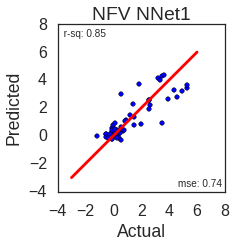

In [43]:
nn1_preds = net1.predict(x_test)
nn1_mse = float(mean_squared_error(nn1_preds, y_test))
nn1_r2 = float(sps.pearsonr(nn1_preds, y_test.reshape(y_test.shape[0],1))[0][0])

cf.scatterplot_results(nn1_preds, y_test, nn1_mse, nn1_r2, DRUG, 'NNet1', figsize=std)